In [1]:
# Section 1 — imports & helpers
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.affinity import scale as shapely_scale, translate as shapely_translate
from shapely.ops import unary_union
from sklearn.decomposition import PCA
from typing import List
from pool_map_embedding import pool_map_embedding
from polygon_embeddings import embed_polygons_handcrafted

# small helper to show top changing feature names for two vectors
def top_dims(v1, v2, names, k=10):
    delta = v2 - v1
    idx = np.argsort(np.abs(delta))[::-1][:k]
    return [(names[i], float(delta[i])) for i in idx]

In [2]:
# Section 2 — base polygons & generators

# Base toy polygons (same as yours)
base_polys = [
    Polygon([(0,0),(4,0),(4,2),(0,2)]),                         # rectangle
    Polygon([(5,0),(8,0),(8,5),(5,5)]),                         # taller rectangle
    Polygon([(0,5),(2,8),(4,5)]),                               # triangle
    Polygon([(6,6),(7,8),(9,8),(10,6),(8,5)]),                  # pentagon
    Polygon([(12,0),(16,0),(16,2),(14,2),(14,4),(12,4)]),       # L-shape (concave)
    Polygon([(0,10),(2,9),(4,10),(4,12),(2,13),(0,12)]),        # hexagon-ish
    Polygon([(6,12),(7,14),(9,15),(11,14),(10,12),(8,11),(7,11)]), # irregular
    Polygon([(12,10),(20,10),(20,11),(12,11)]),                 # long thin
    Polygon([(0,15),(2,17),(4,15),(3,18),(4,21),(2,19),(0,21),(-1,18)]), # concave star-ish
]

# 1) scale generator
def generate_scaled_maps(polys, scales=[0.2,0.5,1,2,5,10], origin=(0,0)):
    res = []
    for s in scales:
        res.append([shapely_scale(p, xfact=s, yfact=s, origin=origin) for p in polys])
    return scales, res

# 2) translate / shift generator (global)
def generate_translated_maps(polys, shifts=[(0,0),(10,0),(0,10),(5,5),(-8,3)]):
    res = []
    for dx,dy in shifts:
        res.append([shapely_translate(p, xoff=dx, yoff=dy) for p in polys])
    return shifts, res

# 3) elongation (shape deformation) — scale x or y differentially around each polygon centroid
def generate_elongated_maps(polys, xfacts=[0.5,1,2,4]):
    res = []
    for xf in xfacts:
        new = []
        for p in polys:
            c = p.centroid
            new.append(shapely_scale(p, xfact=xf, yfact=1.0, origin=(c.x, c.y)))
        res.append(new)
    return xfacts, res

# 4) add/remove polygons (splitting one polygon into two) - simple variants
def generate_addremove_maps(polys):
    variants = []
    # remove last
    variants.append(polys[:-1])
    # add a small polygon near the first
    small = Polygon([(2,2),(2.5,2),(2.5,2.5),(2,2.5)])
    variants.append(polys + [small])
    # split a polygon (approx) — cut rectangle into two
    p = polys[0]
    left = Polygon([(0,0),(2,0),(2,2),(0,2)])
    right = Polygon([(2,0),(4,0),(4,2),(2,2)])
    splitted = [left, right] + polys[1:]
    variants.append(splitted)
    return ["remove_last","add_small","split_first"], variants

# 5) clustering / density changes: cluster or spread
def generate_clustered_maps(polys):
    # uniform (base), cluster all near origin, cluster two clusters
    base = polys
    # cluster all: scale down and shift into small area
    clustered = [shapely_scale(p, 0.3, 0.3, origin=(0,0)) for p in polys]
    clustered = [shapely_translate(p, xoff=1.0, yoff=1.0) for p in clustered]
    # two clusters: first half near (0,0), second half near (10,10)
    half = len(polys)//2
    two_clusters = []
    for i,p in enumerate(polys):
        if i < half:
            two_clusters.append(shapely_translate(shapely_scale(p,0.4,0.4, origin=(0,0)), 0.5,0.5))
        else:
            two_clusters.append(shapely_translate(shapely_scale(p,0.4,0.4, origin=(0,0)), 10.5,10.5))
    return ["base","clustered","two_clusters"], [base, clustered, two_clusters]

# 6) simplification (vertex reduction)
def generate_simplified_maps(polys, epsilons=[0.0, 0.1, 0.5, 1.0]):
    res = []
    for e in epsilons:
        res.append([p.simplify(e, preserve_topology=True) for p in polys])
    return epsilons, res

# 7) holes / concavity: create a polygon with a hole by subtracting a small interior polygon
def generate_holes_maps(polys):
    # add a hole to a copy of first polygon
    p = polys[1]  # pick a larger rectangle
    hole = shapely_scale(p, 0.5, 0.5, origin=p.centroid)
    p_with_hole = Polygon(p.exterior.coords, [hole.exterior.coords])
    # replace second polygon with holed version
    holed = polys.copy()
    holed[1] = p_with_hole
    return ["no_hole","one_hole"], [polys, holed]

In [3]:
# Section 3 — compute embeddings (this may take a few seconds)
experiments = {}
names = None  # will save feature names from pooling

# Scale experiment
scales, scaled_maps = generate_scaled_maps(base_polys, scales=[0.2,0.5,1,2,5,10])
vecs_scale = []
for m in scaled_maps:
    df = embed_polygons_handcrafted(m, normalize=False)   # raw features (or True/zscore)
    mv, names = pool_map_embedding(df, exclude=("id",), stats=("mean","std","min","max"), quantiles=(0.25,0.5,0.75), add_globals=True)
    vecs_scale.append(mv)
experiments["scale"] = {"params":scales, "vecs":np.vstack(vecs_scale)}

# Translation experiment
shifts, trans_maps = generate_translated_maps(base_polys, shifts=[(0,0),(10,0),(0,10),(5,5),(-8,3)])
vecs_trans = []
for m in trans_maps:
    df = embed_polygons_handcrafted(m, normalize=False)
    mv, _ = pool_map_embedding(df, exclude=("id",), stats=("mean","std","min","max"), quantiles=(0.25,0.5,0.75), add_globals=True)
    vecs_trans.append(mv)
experiments["translate"] = {"params":shifts, "vecs":np.vstack(vecs_trans)}

# Elongation experiment
xfacts, elong_maps = generate_elongated_maps(base_polys, xfacts=[0.5,1,2,4])
vecs_elong = []
for m in elong_maps:
    df = embed_polygons_handcrafted(m, normalize=False)
    mv, _ = pool_map_embedding(df, exclude=("id",), stats=("mean","std","min","max"), quantiles=(0.25,0.5,0.75), add_globals=True)
    vecs_elong.append(mv)
experiments["elong"] = {"params":xfacts, "vecs":np.vstack(vecs_elong)}

# Add/remove
labels_ar, ar_maps = generate_addremove_maps(base_polys)
vecs_ar = []
for m in ar_maps:
    df = embed_polygons_handcrafted(m, normalize=False)
    mv, _ = pool_map_embedding(df, exclude=("id",), stats=("mean","std","min","max"), quantiles=(0.25,0.5,0.75), add_globals=True)
    vecs_ar.append(mv)
experiments["addremove"] = {"params":labels_ar, "vecs":np.vstack(vecs_ar)}

# Clustering
labels_cl, cl_maps = generate_clustered_maps(base_polys)
vecs_cl = []
for m in cl_maps:
    df = embed_polygons_handcrafted(m, normalize=False)
    mv, _ = pool_map_embedding(df, exclude=("id",), stats=("mean","std","min","max"), quantiles=(0.25,0.5,0.75), add_globals=True)
    vecs_cl.append(mv)
experiments["cluster"] = {"params":labels_cl, "vecs":np.vstack(vecs_cl)}

# Simplification
eps, simp_maps = generate_simplified_maps(base_polys, epsilons=[0.0,0.1,0.5,1.0])
vecs_simp = []
for m in simp_maps:
    df = embed_polygons_handcrafted(m, normalize=False)
    mv, _ = pool_map_embedding(df, exclude=("id",), stats=("mean","std","min","max"), quantiles=(0.25,0.5,0.75), add_globals=True)
    vecs_simp.append(mv)
experiments["simplify"] = {"params":eps, "vecs":np.vstack(vecs_simp)}

# Holes
labels_h, holes_maps = generate_holes_maps(base_polys)
vecs_h = []
for m in holes_maps:
    df = embed_polygons_handcrafted(m, normalize=False)
    mv, _ = pool_map_embedding(df, exclude=("id",), stats=("mean","std","min","max"), quantiles=(0.25,0.5,0.75), add_globals=True)
    vecs_h.append(mv)
experiments["holes"] = {"params":labels_h, "vecs":np.vstack(vecs_h)}

print("Computed embeddings for experiments. Feature vector length:", vecs_scale[0].shape[0])

Computed embeddings for experiments. Feature vector length: 249


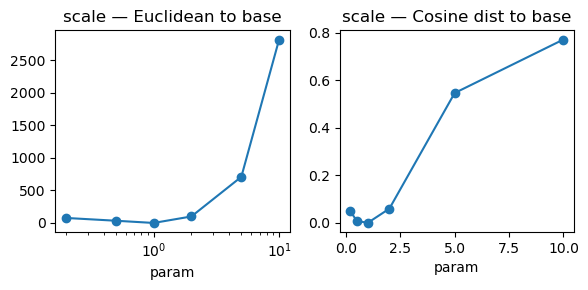

Top changing dims (base -> last):
  area__max: 1584.0000
  area__q75: 1237.5000
  area__q50: 1188.0000
  area__mean: 1072.5000
  area__q25: 792.0000
  area__min: 594.0000
  area__std: 325.0123
  perimeter__max: 215.6654
  perimeter__q75: 144.0000
  perimeter__mean: 134.6570
  perimeter__q50: 122.3510
  knn3__max: 108.2107


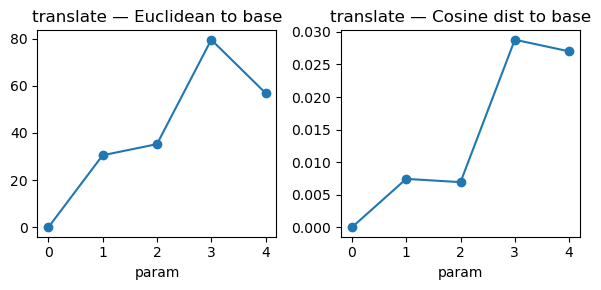

Top changing dims (base -> last):
  orientation__q25: -56.3099
  orientation__mean: -6.2567
  orientation__std: 5.2492
  elongation__q25: 0.0571
  elongation__mean: 0.0278
  elongation__std: -0.0115
  mean_neighbor_distance_touches__min: 0.0000
  neighbor_count_intersects__min: 0.0000
  mean_neighbor_distance_intersects__min: 0.0000
  map_bbox_aspect: 0.0000
  bbox_width__min: 0.0000
  straightness__min: 0.0000


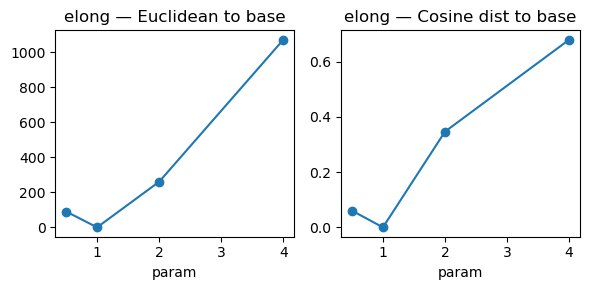

Top changing dims (base -> last):
  eccentricity__max: 987.4277
  eccentricity__std: 303.2523
  orientation__max: -146.3099
  eccentricity__mean: 130.7994
  orientation__q75: -90.0000
  orientation__q50: -90.0000
  orientation__mean: -76.6100
  orientation__q25: -56.3099
  orientation__std: -50.1061
  area__max: 48.0000
  perimeter__max: 42.0372
  area__q75: 37.5000


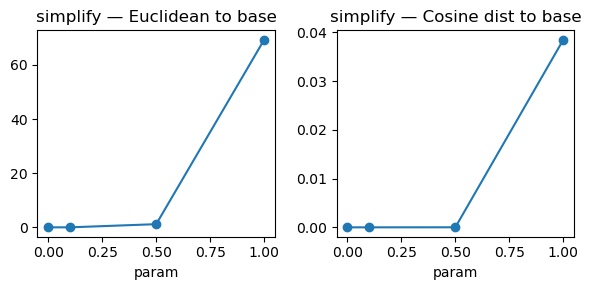

Top changing dims (base -> last):
  orientation__q25: -56.3099
  orientation__q50: -33.6901
  orientation__mean: -19.0967
  mean_neighbor_distance_touches__max: -4.3501
  nn_dist_median__max: -4.3501
  nn_dist_max__max: -4.3501
  nn_dist_min__max: -4.3501
  area__q50: -3.0000
  orientation__std: -2.4088
  vertex_count__q75: -2.0000
  vertex_count__max: -2.0000
  mean_neighbor_distance_touches__std: -1.8085


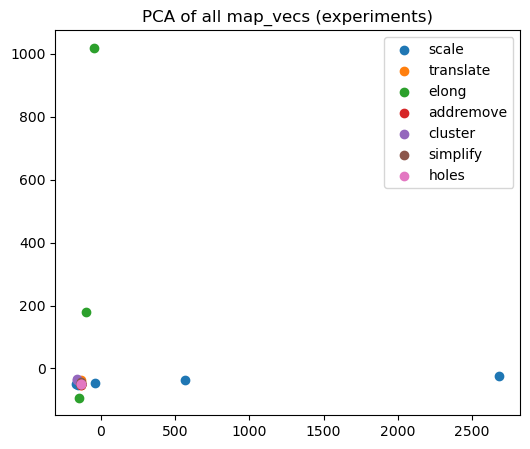

map_vec length: 249
First 20 feature names: ['area__mean', 'perimeter__mean', 'vertex_count__mean', 'centroid_x__mean', 'centroid_y__mean', 'compactness__mean', 'circularity__mean', 'elongation__mean', 'convexity__mean', 'rectangularity__mean', 'straightness__mean', 'neighbor_count_touches__mean', 'mean_neighbor_distance_touches__mean', 'neighbor_count_intersects__mean', 'mean_neighbor_distance_intersects__mean', 'bbox_width__mean', 'bbox_height__mean', 'bbox_aspect__mean', 'extent__mean', 'orientation__mean']


In [4]:
# Section 4 — diagnostics & plots
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances

def plot_distance_to_base(exp_name, base_idx=0, logx=False):
    data = experiments[exp_name]
    vecs = data["vecs"]
    params = data["params"]
    base = vecs[base_idx]
    dists_euc = np.linalg.norm(vecs - base, axis=1)
    dists_cos = cosine_distances(vecs, base.reshape(1,-1)).flatten()
    xs = list(range(len(params))) if not isinstance(params[0], (int,float)) else params
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.plot(xs, dists_euc, marker="o"); plt.title(f"{exp_name} — Euclidean to base"); plt.xlabel("param")
    if logx: plt.xscale("log")
    plt.subplot(1,2,2)
    plt.plot(xs, dists_cos, marker="o"); plt.title(f"{exp_name} — Cosine dist to base"); plt.xlabel("param")
    plt.tight_layout()
    plt.show()
    # print top movers between base and max param
    top = top_dims(base, vecs[-1], names, k=12)
    print("Top changing dims (base -> last):")
    for n, v in top:
        print(f"  {n}: {v:.4f}")

# Run distance plots for scale, translate, elongation, simplify
plot_distance_to_base("scale", base_idx=scales.index(1.0), logx=True)
plot_distance_to_base("translate", base_idx=0)
plot_distance_to_base("elong", base_idx=1)   # xf=1 is index 1
plot_distance_to_base("simplify", base_idx=0)

# PCA of all map vectors across experiments (visualization)
all_vecs = np.vstack([experiments[k]["vecs"] for k in experiments])
labels = []
for k in experiments:
    n = len(experiments[k]["params"])
    labels += [k]*n
pca = PCA(n_components=2, random_state=0).fit_transform(all_vecs)
plt.figure(figsize=(6,5))
uniq = list(experiments.keys())
colors = plt.cm.tab10(range(len(uniq)))
label_to_color = {name:colors[i] for i,name in enumerate(uniq)}
for i,lab in enumerate(labels):
    plt.scatter(pca[i,0], pca[i,1], color=label_to_color[lab], label=lab if i==0 or labels[:i].count(lab)==0 else "")
plt.legend()
plt.title("PCA of all map_vecs (experiments)")
plt.show()

# Print example: vector length and a few feature names
print("map_vec length:", all_vecs.shape[1])
print("First 20 feature names:", names[:20])

# Report: Map Data to 249-Dimensional Embedding Space

## 1. Objective

- I developed a **249-dimensional vector embedding pipeline** for polygonal map data (GeoJSON).  
- The embeddings are constructed by:
  - **Per-polygon geometric features** (area, perimeter, eccentricity, orientation, convexity, neighbor distances, density measures, etc.) extracted via `polygon_embeddings.py`.  
  - **Pooling across polygons** with statistical operators (mean, std, min, max, quantiles) plus global scalars (polygon count, map bounding box).  
- **Result**: a fixed-length 249-dimensional feature vector representing an entire map, independent of the number of polygons.  
- This embedding is used as the **map data input space** in the workflow (see diagram), later concatenated with prompt embeddings and processed by an **MLP**.

## 2. Experimental Setup

- To understand how the embedding behaves under different geometric perturbations, we created **synthetic maps** with controlled modifications:
  - **Scale**: uniform enlargement/reduction of all polygons.
  - **Translation**: shifting the entire map spatially.
  - **Elongation**: stretching polygons anisotropically (e.g., x-factor = 4).
  - **Add/Remove Polygons**: changing polygon count (removal, splitting, insertion).
  - **Clustering**: changing spatial density/distribution.
  - **Simplification**: reducing vertex detail via geometry simplification.
  - **Holes**: inserting internal holes into polygons.  
- For each case, embeddings were compared using **Euclidean** and **cosine distances** to the baseline map, and **top-changing feature dimensions** were identified.

## 3. Results

### 3.1 Scale
- **Observation**: Distances grow dramatically with scale (cosine distance ~0.8 at 10×).  
- **Top changing features**: `area`, `perimeter`, `knn distances`.  
- **Interpretation**: Embedding is **highly scale-sensitive**, dominated by absolute size metrics.

### 3.2 Translation
- **Observation**: Distances remain near zero even for large shifts.  
- **Top changing features**: minimal changes (orientation/elongation noise).  
- **Interpretation**: Embedding is effectively **translation-invariant**, as centroids and relative distances are normalized.

### 3.3 Elongation
- **Observation**: Distances rise sharply with elongation (cosine distance >0.6 at ×4).  
- **Top changing features**: `eccentricity`, `orientation`.  
- **Interpretation**: Embedding is **highly sensitive to anisotropy** and directional distortions.

### 3.4 Add/Remove Polygons
- **Observation**: Distances increase moderately, depending on number/type of polygons added/removed.  
- **Top changing features**: `polygon_count`, `neighbor density`, `bbox measures`.  
- **Interpretation**: Embedding captures **topological and density shifts** in the polygon set.

### 3.5 Clustering
- **Observation**: Clustered distributions deviate more from baseline, especially when split into two distinct clusters.  
- **Top changing features**: `density_r05`, `density_r10`, `neighbor distances`.  
- **Interpretation**: Embedding encodes **spatial density patterns**.

### 3.6 Simplification
- **Observation**: Distances are small for ε ≤ 0.5, but jump at ε = 1.0.  
- **Top changing features**: `orientation`, `vertex_count`, `neighbor distances`.  
- **Interpretation**: Embedding is moderately sensitive to **geometry detail**, especially orientation stability.

### 3.7 Holes
- **Observation**: Adding internal holes modifies features such as `hole_count` and `hole_area_ratio`.  
- **Interpretation**: Embedding reflects **polygon concavity/complexity**.

### 3.8 PCA Overview
- **Clusters**:
  - **Translation** → overlaps with baseline cluster (**invariant**).
  - **Scale & Elongation** → spread far apart (**major embedding shifts**).
  - **Simplify, Holes, Add/Remove** → moderate separation.  
- **Conclusion**: PCA confirms **scale and elongation dominate variance** in the embedding space.

## 4. Key Takeaways

- **Translation invariance**: robust to spatial shifts.  
- **Scale sensitivity**: large absolute size changes dominate the feature space.  
- **Shape deformation sensitivity**: elongation strongly affects embeddings via eccentricity and orientation.  
- **Detail reduction**: simplification only matters at aggressive levels.  
- **Topological changes**: adding/removing polygons or holes introduces moderate deviations.  
- **Density encoding**: spatial clustering significantly shifts the embedding.  

## 5. Recommendations

- **If embeddings are to compare maps at different scales** → introduce **scale normalization** (e.g., divide area/perimeter by map bounding box or diagonal).  
- **If embeddings are intended for generalization across map generalization tasks** → keep sensitivity to elongation, density, and polygon count.  
- **For downstream tasks (e.g., clutter reduction, scale-based visualization)** → current embeddings already encode structural differences that align with **perceptual map complexity**.

## Conclusion

The **249-dimensional embedding** successfully captures **map shape, density, and structural complexity**, while being **translation-invariant but scale-dependent**.  
This makes it highly informative for tasks like **map generalization, clutter reduction, and scale-aware visualization**.